In [1]:
### This began with a great head start from Johnowhitaker:
### https://zindi.africa/competitions/fowl-escapades/discussions/675

In [2]:
### And the first serious attempt to ensure I can reproduce identical results with a FastAI model & notebook
### the jupyter notebook was started with this command:
### env PYTHONHASHSEED=42 jupyter notebook
### per this FastAI thread: 
### https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/15

In [3]:
### next step in reproducibility is to set up the various seeds within the notebook
### and this will need to be called:
###  You have to run random_seed(0), before the first fit;
###  You have to run it before creating the databunch;
###  And you have to call it every time for each different time you call fit.

def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [4]:
!ls

blend_f18f.csv			      fastai_v7.csv
blend_f18f_v2.csv		      five-sec-samples.ipynb
blend_f18f_v3.csv		      models
blend.R				      repro-fowl-A17a.ipynb
blend_v6_v7.csv			      repro-fowl-A17a-v2.ipynb
colab-follow-along.ipynb	      repro-fowl-A17b.ipynb
colab-improve-try1.ipynb	      repro-fowl-A17c.ipynb
colab-improve-try2.ipynb	      repro-fowl-A17d.ipynb
colab-improve-try3-rn34.ipynb	      repro-fowl-A17e.ipynb
colab-improve-try4-rn50.ipynb	      repro-fowl-A17f.ipynb
colab-improve-try5-rn50v2.ipynb       repro-fowl-data-creation.ipynb
colab-improve-try6-densenet201.ipynb  Rsplits
day1.R				      Rsplits_Test
default_plus_WBSR.csv		      Rsplits_Train
default_sub.csv			      R_splitter.R
fastai_A17a.csv			      SampleSubmission.csv
fastai_A17av2.csv		      splits_max_prob_row.csv
fastai_A17b.csv			      StarterNotebook.ipynb
fastai_A17c.csv			      Test
fastai_A17d.csv			      Test.csv
fastai_A17e.csv			      TestSplits.csv
fastai_f18c.csv			      Test_Wavs
fastai_f18d.csv			   

In [5]:
import pandas as pd
sub = pd.read_csv('SampleSubmission.csv')
sub.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,...,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
0,019OYB,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01S9OX,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,02CS12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,02LM3W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0C3A2V,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train = pd.read_csv('Train.csv')
train.head()

,ID,common_name
0,MBMG2C,Ring-necked Dove
1,K8LJSB,Ring-necked Dove
2,OGD9L6,Ring-necked Dove
3,581PCQ,Ring-necked Dove
4,P91M1F,Ring-necked Dove


In [7]:
birds = sub.columns[1:]
birds

Index(['Ring-necked Dove', 'Black Cuckoo', 'Red-chested Cuckoo',
       'Fiery-necked Nightjar', 'Green Wood Hoopoe', 'Crested Barbet',
       'Cape Batis', 'Olive Bushshrike', 'Orange-breasted Bushshrike',
       'Bokmakierie', 'Black-backed Puffback', 'Southern Boubou',
       'Black-headed Oriole', 'Fork-tailed Drongo',
       'African Paradise Flycatcher', 'Sabota Lark', 'Eastern Clapper Lark',
       'Rufous-naped Lark', 'Dark-capped Bulbul', 'Sombre Greenbul',
       'Long-billed Crombec', 'African Reed Warbler', 'Rattling Cisticola',
       'Levaillants Cisticola', 'Tawny-flanked Prinia', 'Karoo Prinia',
       'Bar-throated Apalis', 'Green-backed Camaroptera',
       'Chestnut-vented Warbler', 'Cape White-eye', 'Karoo Scrub Robin',
       'White-browed Scrub Robin', 'Cape Robin-Chat',
       'White-browed Robin-Chat', 'Chorister Robin-Chat',
       'Southern Double-collared Sunbird', 'White-bellied Sunbird',
       'African Pipit', 'African Rock Pipit', 'Cape Bunting'],
      d

In [8]:
# Add file names
train['file_name'] = 'Train/'+train['ID']+'.mp3'
sub['file_name'] = 'Test/'+sub['ID']+'.mp3'

In [9]:
import IPython.display as ipd
from matplotlib import pyplot as plt
import librosa

In [10]:
# Checking that the spectrograms were generated successfully:
import glob
ims = glob.glob('Train/*.png')
train['img_path'] = train['file_name'].str[:-4]+'.png'
print(len(ims), len(train))

1857 1857


In [11]:
# Similarly, test now has rows for files that have had spectrograms created.
sub['img_path'] = sub['file_name'].str[:-4]+'.png'
ims = glob.glob('Test/*.png')
test = sub.loc[sub.img_path.isin(ims)]
print(len(sub), len(test))

911 911


In [12]:
from fastai.vision import *

In [13]:
random_seed(42,use_cuda=True)

data = ImageDataBunch.from_df(path="./", df=train[["img_path", "common_name"]], ds_tfms=get_transforms(), size=224, num_workers=0)\
  .split_by_rand_pct(valid_pct=0.20, seed=42)\
  .label_from_df(cols='common_name')\
  .databunch(bs=8)\
  .normalize(imagenet_stats)

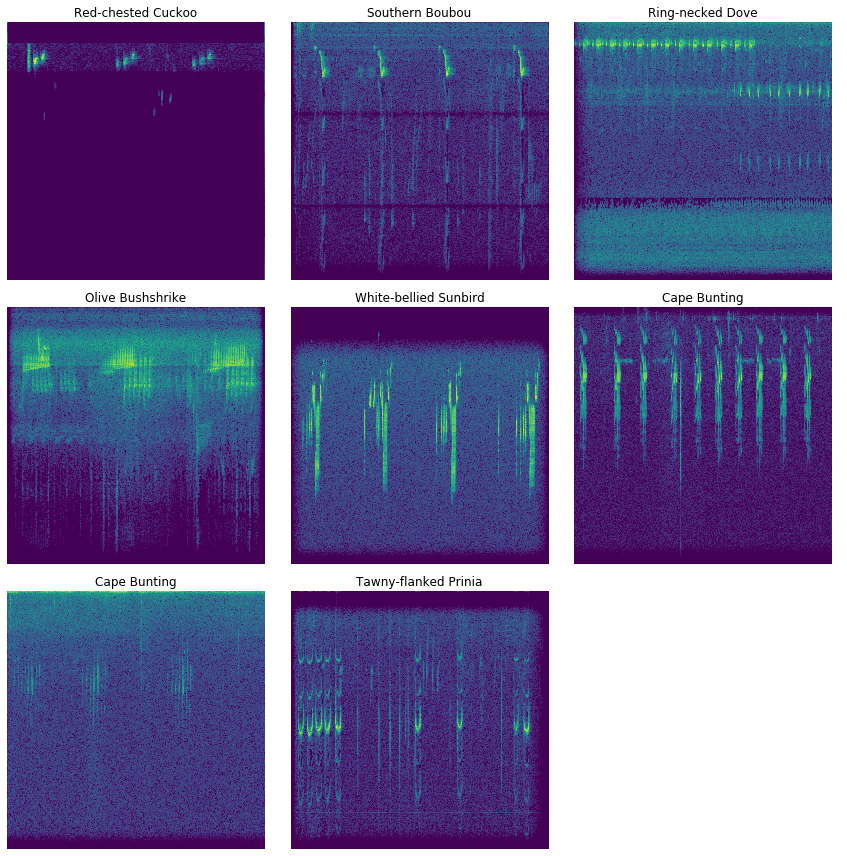

In [14]:
data.show_batch(rows=3)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


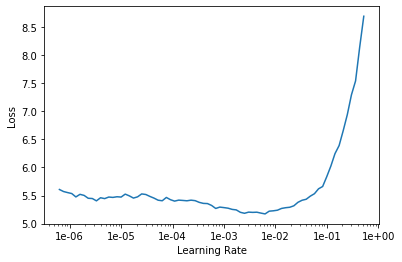

In [15]:
# Going to set this a lot
random_seed(42,use_cuda=True)

# Create a learner and pick a learning rate
learn = cnn_learner(data, models.densenet201, metrics=[error_rate])
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,5.112929,3.878327,0.922559,01:11
1,4.650806,3.556821,0.888889,01:09
2,4.029719,3.265919,0.845118,01:11
3,3.317950,2.972339,0.764310,01:10
4,3.002263,2.740194,0.717172,01:08
5,2.527204,2.517191,0.636364,01:10
6,2.156631,2.492106,0.639731,01:11
7,1.948899,2.504422,0.602694,01:10
8,1.792591,2.051744,0.548822,01:10
9,1.593810,2.076586,0.538721,01:10


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


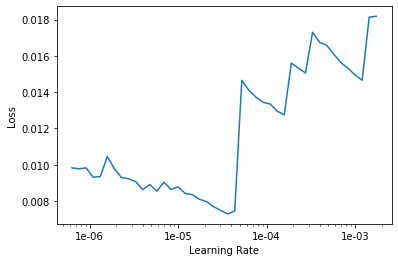

In [16]:
# Going to set this a lot
random_seed(42,use_cuda=True)

# Train the head of the model
learn.fit_one_cycle(40, 1e-3)
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.135477,2.641027,0.464646,01:10
1,0.360096,1.748178,0.410774,01:09
2,0.172566,1.664467,0.377104,01:10


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


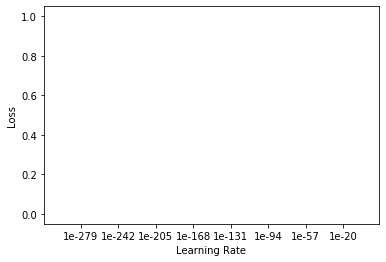

In [17]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.fit_one_cycle(3, 1e-3)
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.070412,1.677528,0.377104,01:10
1,0.017010,1.626622,0.380471,01:11
2,0.060890,1.635599,0.380471,01:09


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


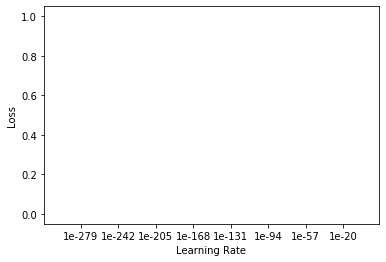

In [18]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.fit_one_cycle(3, 5e-5)
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


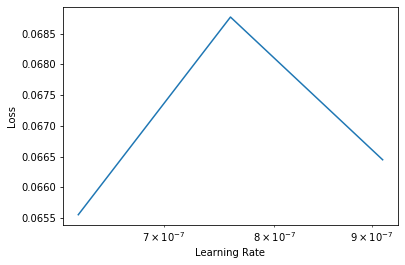

In [19]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [20]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.fit_one_cycle(4, slice(5e-6, 5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.017545,1.623350,0.363636,01:30
1,0.039813,1.755576,0.367003,01:31
2,0.135724,1.594751,0.326599,01:32
3,0.100299,1.600484,0.329966,01:32


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


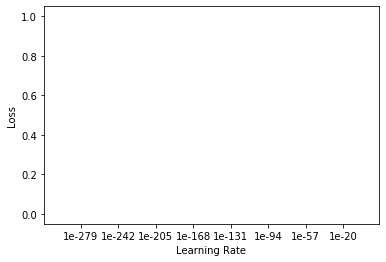

In [21]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.lr_find()
learn.recorder.plot()

In [22]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.fit_one_cycle(4, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.015502,1.573647,0.346801,01:31
1,0.011103,1.522160,0.323232,01:31
2,0.013328,1.537864,0.326599,01:31
3,0.048382,1.590680,0.323232,01:30


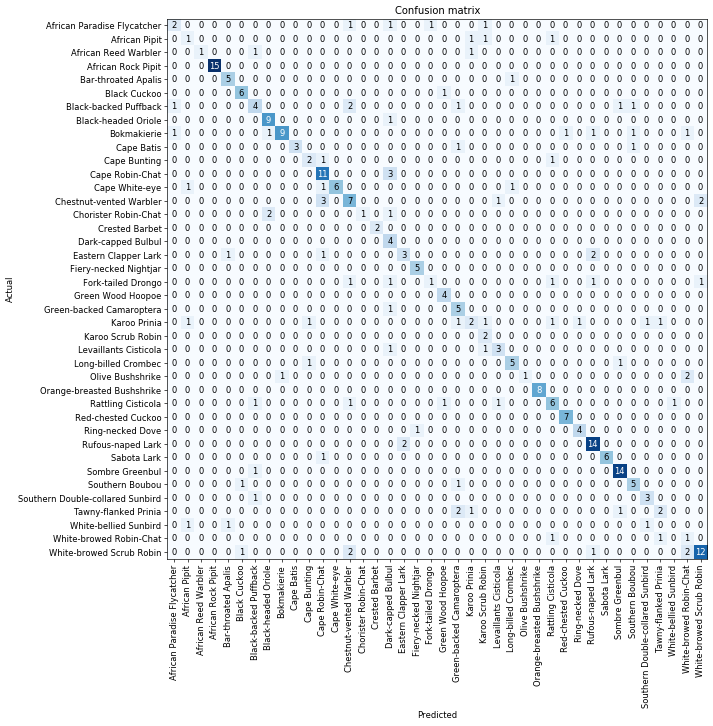

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [24]:
# Going to set this a lot
random_seed(42,use_cuda=True)

# Add the test data as a test set for the model
src = (ImageList.from_df(path='./', df=test, cols='img_path')) # Note test, not sub, as we only have spectrograms for the ims in test
learn.data.add_test(src)

In [25]:
# Get predictions
preds, y = learn.get_preds(DatasetType.Test)

In [26]:
# Add preds to test
test = test.copy()
for b in birds:
  test[b] = preds[:,learn.data.classes.index(b)]
test.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,...,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting,file_name,img_path
0,019OYB,3.540741e-05,1.073407e-05,0.000012,0.999915,1.681146e-06,2.072428e-07,0.000002,0.000016,0.000001,...,2.842235e-08,7.743124e-08,6.561463e-07,7.488950e-08,4.810030e-10,7.029084e-09,1.153413e-08,7.470688e-08,Test/019OYB.mp3,Test/019OYB.png
1,01S9OX,4.182037e-07,5.823620e-07,0.000033,0.000054,9.923575e-07,1.574679e-05,0.000008,0.000111,0.032406,...,2.147375e-05,7.995516e-06,1.691779e-05,1.098841e-08,9.359354e-08,6.650069e-06,1.660625e-06,2.766066e-06,Test/01S9OX.mp3,Test/01S9OX.png
2,02CS12,1.776088e-04,2.205120e-04,0.001568,0.006282,1.497301e-02,2.731059e-03,0.014637,0.000377,0.003387,...,7.528758e-04,3.068109e-03,5.551805e-05,1.579958e-01,2.012021e-03,3.313535e-01,1.275596e-03,4.604014e-02,Test/02CS12.mp3,Test/02CS12.png
3,02LM3W,7.206995e-06,1.334820e-07,0.000035,0.000001,2.915187e-06,2.084644e-05,0.000032,0.995381,0.000011,...,5.607872e-09,8.097824e-09,2.947097e-07,8.564666e-08,3.516095e-10,4.701953e-09,8.931151e-09,7.042653e-09,Test/02LM3W.mp3,Test/02LM3W.png
4,0C3A2V,5.162363e-04,3.802653e-04,0.003782,0.000096,3.727275e-02,1.872759e-03,0.000881,0.000193,0.000406,...,3.823502e-03,1.840027e-02,1.679978e-03,1.025812e-02,4.000877e-03,4.782984e-03,2.826742e-04,4.121745e-05,Test/0C3A2V.mp3,Test/0C3A2V.png


In [27]:
# Merge back into submission DF, adding a low prob prediction for rows where we had no image generated
cols = ['ID']
for b in birds:
  cols.append(b)
ss = pd.merge(sub['ID'], test[cols], on='ID', how='left' )
ss = ss.fillna(1/40) # For those with NaNs (if you only generated spectrograms for a subset of the test mp3s)
ss.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,...,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
0,019OYB,3.540741e-05,1.073407e-05,0.000012,0.999915,1.681146e-06,2.072428e-07,0.000002,0.000016,0.000001,...,1.716639e-07,5.948815e-09,2.842235e-08,7.743124e-08,6.561463e-07,7.488950e-08,4.810030e-10,7.029084e-09,1.153413e-08,7.470688e-08
1,01S9OX,4.182037e-07,5.823620e-07,0.000033,0.000054,9.923575e-07,1.574679e-05,0.000008,0.000111,0.032406,...,1.075451e-07,4.136172e-06,2.147375e-05,7.995516e-06,1.691779e-05,1.098841e-08,9.359354e-08,6.650069e-06,1.660625e-06,2.766066e-06
2,02CS12,1.776088e-04,2.205120e-04,0.001568,0.006282,1.497301e-02,2.731059e-03,0.014637,0.000377,0.003387,...,9.114742e-02,4.326825e-06,7.528758e-04,3.068109e-03,5.551805e-05,1.579958e-01,2.012021e-03,3.313535e-01,1.275596e-03,4.604014e-02
3,02LM3W,7.206995e-06,1.334820e-07,0.000035,0.000001,2.915187e-06,2.084644e-05,0.000032,0.995381,0.000011,...,1.591242e-08,2.086664e-05,5.607872e-09,8.097824e-09,2.947097e-07,8.564666e-08,3.516095e-10,4.701953e-09,8.931151e-09,7.042653e-09
4,0C3A2V,5.162363e-04,3.802653e-04,0.003782,0.000096,3.727275e-02,1.872759e-03,0.000881,0.000193,0.000406,...,3.488811e-04,9.215765e-04,3.823502e-03,1.840027e-02,1.679978e-03,1.025812e-02,4.000877e-03,4.782984e-03,2.826742e-04,4.121745e-05


In [28]:
# Check shape
ss.shape

(911, 41)

In [29]:
# Save predictions
ss.to_csv('fastai_A17f.csv', index=False)

# Save model
learn.save('model-A17f')

In [30]:
# LB Score v6: 1.55 (val loss 1.73)
# LB Score v7: 1.698 (val loss 1.71, but lower class accuracy)